In [77]:
import torch
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt

In [78]:
' ! Importer un dataset prefait (CIFAR10)'

training_dataset = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.ToTensor()
)

test_dataset = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [79]:
print(training_dataset)
print(training_dataset.data.shape)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
(50000, 32, 32, 3)


In [80]:
from torch.utils.data import ConcatDataset

mean = torch.zeros(3) # ! Initialiser pour 3 canaux
std = torch.zeros(3) # ! Initialiser pour 3 canaux

combined_data = ConcatDataset([training_dataset, test_dataset])

# Calculer la moyenne et l'écart-type
for image, _ in combined_data:
    mean += image.mean(dim=(1, 2))  # ! Moyenne sur H, W pour chaque canal
    std += image.std(dim=(1, 2))    # ! Écart-type sur H, W pour chaque canal

# Moyenne globale sur toutes les images
mean /= len(combined_data)
std /= len(combined_data)

print(f"Mean: {mean}")
print(f"Variance: {std}")

Mean: tensor([0.4919, 0.4827, 0.4472])
Variance: tensor([0.2023, 0.1994, 0.2010])


In [81]:
training_dataset_v2 = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize((mean), (std))
    ])
)

test_dataset_v2 = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.ToTensor(), T.Normalize((mean), (std))])
)

Files already downloaded and verified
Files already downloaded and verified


In [82]:
from torch.utils.data import ConcatDataset

mean = torch.zeros(3) # ! Initialiser pour 3 canaux
std = torch.zeros(3) # ! Initialiser pour 3 canaux

combined_data = ConcatDataset([training_dataset_v2, test_dataset_v2])

# Calculer la moyenne et l'écart-type
for image, _ in combined_data:
    mean += image.mean(dim=(1, 2))  # ! Moyenne sur H, W pour chaque canal
    std += image.std(dim=(1, 2))    # ! Écart-type sur H, W pour chaque canal

# Moyenne globale sur toutes les images
mean /= len(combined_data)
std /= len(combined_data)

print(f"Mean: {mean}")
print(f"Variance: {std}")

Mean: tensor([-0.0744, -0.0766, -0.0711])
Variance: tensor([1.0732, 1.0719, 1.0590])


In [83]:
from torch.utils.data import DataLoader

batch_size = 64  # Taille du batch

# Création des DataLoader pour entraîner et tester
train_dataloader_v2 = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader_v2 = DataLoader(test_dataset, batch_size=batch_size)

# Vérification de la forme des données
for X, y in test_dataloader_v2:
    print(f"Shape X : {X.shape}")  # ! Batch, Canaux, Hauteur, Largeur
    print(f"Shape y : {y.shape}")  # ! Batch de labels
    break


Shape X : torch.Size([64, 3, 32, 32])
Shape y : torch.Size([64])


In [84]:
training_dataset_v2.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [85]:
cifar10_labels = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

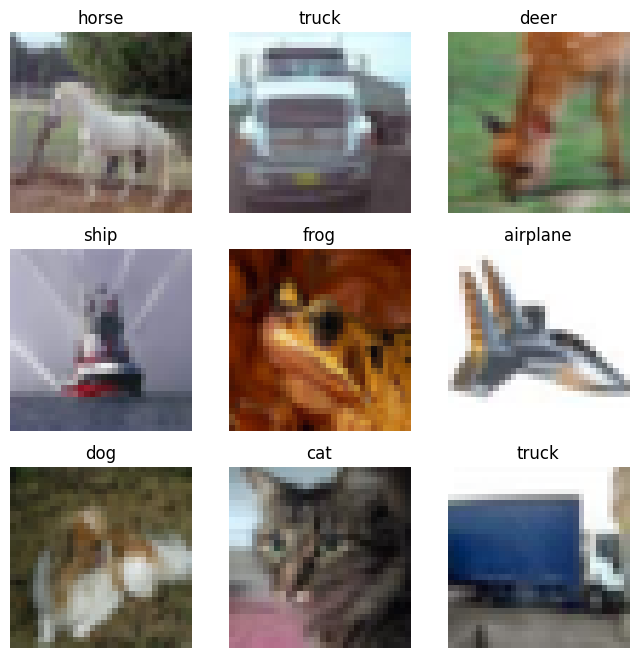

In [86]:
# Créer la figure
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    
    figure.add_subplot(rows, cols, i)
    plt.title(cifar10_labels[label])
    plt.axis("off")
    
    # Convertir (C, H, W) en (H, W, C)
    plt.imshow(img.permute(1, 2, 0))  

plt.show()


In [87]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # ? Bloc 1 : 2 Convolutions + BatchNorm + Dropout
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.MaxPool2d(kernel_size=2, stride=2)  # ! Réduction → (16x16)
        )

        # ? Bloc 2 : 2 Convolutions + BatchNorm + Dropout
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            nn.MaxPool2d(kernel_size=2, stride=2)  # ! Réduction → (8x8)
        )

        # ? Bloc 3 : 2 Convolutions + BatchNorm + Dropout
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(0.1),

            nn.MaxPool2d(kernel_size=2, stride=2)  # ! Réduction → (4x4)
        )

        # ? Fully connected layers (MLP)
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 10)  # 10 classes pour CIFAR-10
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.mlp(x)
        return x

In [88]:
class MiniVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniVGG, self).__init__()
        
        self.features = nn.Sequential(
            # Bloc 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # réduction → 16x16

            # Bloc 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # réduction → 8x8

            # Bloc 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # réduction → 4x4
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)       # (N, 256, 4, 4)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

In [89]:
device = "mps" if torch.mps.is_available() else "cpu"
print(f"Accélérateur: {device}")

# Instancier le modèle (MiniVGG) et la fonction de perte
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)  # * Expect raw logits

import torch.optim as optim
optimizer = optim.AdamW(cnn.parameters(), lr=1e-3, weight_decay=1e-4)

# Scheduler qui réduit le LR d’un facteur 0.1 tous les 15 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

epochs = 10


Accélérateur: mps


In [90]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/mnist_experiment_6')

def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        # Forward
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Statistiques
        epoch_loss += loss.item()
        correct += (pred.argmax(dim=1) == y).float().sum().item()
    
    return epoch_loss / len(dataloader), (correct / len(dataloader.dataset)) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y).float().sum().item()
    
    return test_loss / len(dataloader), (correct / len(dataloader.dataset)) * 100

def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, scheduler, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Entraînement
        train_loss, train_acc = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc}, epoch)

        # Évaluation
        test_loss, test_acc = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': test_acc}, epoch)

        # Étape du scheduler (réduction du LR si besoin)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} complete - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%\n")


In [ ]:
train_and_test(train_dataloader_v2, test_dataloader_v2, cnn, loss_fn, optimizer, scheduler, epochs, batch_size)


Epoch 1/10
Epoch 1/10 complete - Train Loss: 1.3141, Train Acc: 52.68% | Test Loss: 0.9645, Test Acc: 66.23%

Epoch 2/10
Epoch 2/10 complete - Train Loss: 0.8893, Train Acc: 69.33% | Test Loss: 0.8367, Test Acc: 71.82%

Epoch 3/10
Epoch 3/10 complete - Train Loss: 0.7296, Train Acc: 75.38% | Test Loss: 0.7081, Test Acc: 75.56%

Epoch 4/10


In [ ]:
cnn.eval()
cnn.to("cpu")
torch_input = torch.randn(1, 3, 32, 32)  # ? N (batch_size), C (channels), H (height), W (width)

# Exporter le modèle en ONNX
torch.onnx.export(
    cnn,
    torch_input,
    "model_cifar_ep20.onnx",
    verbose=True,
    input_names=["input"],
    output_names=["output"],
    opset_version=11, # ! Version de l'opset ONNX utilisée
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)

Exported graph: graph(%input : Float(*, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=cpu),
      %conv_block1.0.weight : Float(32, 3, 3, 3, strides=[27, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_block1.0.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_block1.2.weight : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_block1.2.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_block1.2.running_mean : Float(32, strides=[1], requires_grad=0, device=cpu),
      %conv_block1.2.running_var : Float(32, strides=[1], requires_grad=0, device=cpu),
      %conv_block1.4.weight : Float(32, 32, 3, 3, strides=[288, 9, 3, 1], requires_grad=1, device=cpu),
      %conv_block1.4.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_block1.6.weight : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_block1.6.bias : Float(32, strides=[1], requires_grad=1, device=cpu),
      %conv_block